## Median Gross Rent (and other housing characteristics) and QOZs


In [4]:
directory = '/arcgis/samplesdata'

In [5]:
directory = '/arcgis/home'

In [6]:
from arcgis.gis import GIS
gis = GIS("home")

In [7]:
from arcgis.features import GeoAccessor, GeoSeriesAccessor

### Gathering data from the Census API

In [9]:
# install census library
! pip install census
! pip install geopandas

DEPRECATION: Loading egg at /opt/conda/lib/python3.11/site-packages/tflite_model_maker-0.3.4-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /opt/conda/lib/python3.11/site-packages/tflite_model_maker-0.3.4-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.5/32.5 MB 45.8 MB/s eta 0:00:0000:0100:01


In [10]:
# add relevant libraries for census data
from census import Census
import os
import pandas as pd
import geopandas
import requests
import urllib3
import zipfile

In [7]:
# set my api key to call census data
API_KEY = "MY_API_KEY"
c = Census(API_KEY)

In [10]:
# desired variables
# median gross rent
variables = ('B25064_001E')

In [13]:
# getting 2023 Census data for median gross rent
data_2023 = c.acs5.state_county_tract(fields = variables,
                           state_fips='06', # california
                           county_fips = "*",  
                           tract = "*",   
                           year = 2023) # pulling from the most recent ACS

data_2023 = pandas.DataFrame(data_2023)
data_2023.head()

,B25064_001E,state,county,tract
0,3501.0,06,001,400100
1,2949.0,06,001,400200
2,2246.0,06,001,400300
3,2485.0,06,001,400400
4,2154.0,06,001,400500


In [17]:
# doing the same with the 2010 data
data_2010 = c.acs5.state_county_tract(fields = variables,
                           state_fips='06', # california
                           county_fips = "*",  
                           tract = "*",   
                           year = 2010) # pulling from the 2010 ACS

data_2010 = pandas.DataFrame(data_2010)
data_2010.head()

,B25064_001E,state,county,tract
0,2001.0,06,001,400100
1,1342.0,06,001,400200
2,998.0,06,001,400300
3,1387.0,06,001,400400
4,1005.0,06,001,400500


### Structuring Data

Here I'm cleaning and merging the 2010 and 2023 data frames. A GEOID column will be made for both dataframes in order to be the field used for the left merge. This GEOID column will also be helpful when joining the tabular data to boundary layers. 

In [21]:
# creating a GEOID using state, county, tract for both dataframes to make the merging of datasets easier
data_2023["GEOID"] = data_2023["state"] + data_2023["county"] + data_2023["tract"]
data_2010["GEOID"] = data_2010["state"] + data_2010["county"] + data_2010["tract"]

# rename rent columns and change values to numeric for easier data manipulation
data_2023["rent_2023"] = pd.to_numeric(data_2023["B25064_001E"], errors="coerce") # 2023 median gross rent
data_2010["rent_2010"] = pd.to_numeric(data_2010["B25064_001E"], errors="coerce") # 2010 median gross rent

# making subset of 2010 data with only relevant info needed in merge
subset_2010 = data_2010[["GEOID", "rent_2010"]]
subset_2010

,GEOID,rent_2010
0,06001400100,2001.0
1,06001400200,1342.0
2,06001400300,998.0
3,06001400400,1387.0
4,06001400500,1005.0
...,...,...
8052,06115040800,826.0
8053,06115040901,1500.0
8054,06115040902,1608.0
8055,06115041000,1057.0


Once I merge the tables I want to calculate a variable that shows the percent change in rents from 2010 to 2023. Later once the QOZ layer is added I want to see how QOZs interact with changes in rent behavior, and see if there is evidence that rent has had an influence in QOZ designation. 

In [23]:
# merge (left join)
df_merged = data_2023.merge(subset_2010, on="GEOID", how="left")

# adding change over time variable
df_merged["rent_change_pct"] = (
    (df_merged["rent_2023"] - df_merged["rent_2010"]) / 
    df_merged["rent_2010"]) * 100

df_merged

,B25064_001E,state,county,tract,GEOID,rent_2023,rent_2010,rent_change_pct
0,3501.0,06,001,400100,06001400100,3501.0,2001.0,74.962519
1,2949.0,06,001,400200,06001400200,2949.0,1342.0,119.746647
2,2246.0,06,001,400300,06001400300,2246.0,998.0,125.050100
3,2485.0,06,001,400400,06001400400,2485.0,1387.0,79.163663
4,2154.0,06,001,400500,06001400500,2154.0,1005.0,114.328358
...,...,...,...,...,...,...,...,...
9124,2498.0,06,115,040902,06115040902,2498.0,1608.0,55.348259
9125,1125.0,06,115,041001,06115041001,1125.0,NaN,NaN
9126,-666666666.0,06,115,041002,06115041002,-666666666.0,NaN,NaN
9127,794.0,06,115,041101,06115041101,794.0,NaN,NaN


In [24]:
# there's still that extra 2023 rent column, so drop that
df_merged = df_merged.drop(columns=["B25064_001E"])
df_merged.columns

Index(['state', 'county', 'tract', 'GEOID', 'rent_2023', 'rent_2010',
       'rent_change_pct'],
      dtype='object')

### Connecting Boundary Layers

I downloaded the shapefile from the Census website and ended up doing all the joining in R. My R Script can be found in my accompanying [GitHub repo here](https://github.com/orreries/GIS-Web-Map-Project-Lab-3-/blob/main/Joining_for_Rent_Webmap.R).

While doing the join, I also used crosswalks to put the 2010 Census data on 2020 Census tracts, so the 2010 and 2023 Census tract data align. Additionally, I adjusted the 2010 rent prices for inflation using the Consumer Price Index (CPI).

### Making the map!

In [13]:
from arcgis.gis import GIS
gis = GIS("home")

CA_QOZ_Rent_map = gis.map("Los Angeles, CA")
CA_QOZ_Rent_map

Map(center=[4035818.471878221, -13162788.84377388], extent={'xmin': -13194737.537631549, 'ymin': 3997322.61724…

In [15]:
# Item Added From Toolbar
# Title: Cali_Rent | Type: Feature Service | Owner: mwanikialexander
item_draft = gis.content.get("b64f728b0c054d4298fdbe12579a2a45")
item_draft

<Item title:"Cali_Rent" type:Feature Layer Collection owner:mwanikialexander>

<Item title:"QOZs" type:Feature Layer Collection owner:mwanikialexander>
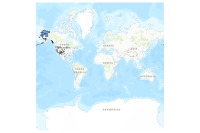

In [16]:
# Item Added From Toolbar
# Title: QOZs | Type: Feature Service | Owner: mwanikialexander
item_QOZ = gis.content.get("75fa10e430af4588a1e5def2a295b35f")
item_QOZ

<Item title:"Calfornia Rent 2010 and 2023 " type:Feature Layer Collection owner:mwanikialexander>
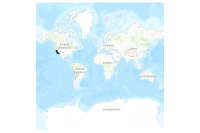

In [17]:
# Item Added From Toolbar
# Title: Calfornia Rent 2010 and 2023  | Type: Feature Service | Owner: mwanikialexander
item_adjusted = gis.content.get("3a0ecec509a64d868c4d940d5d55635a")
item_adjusted

In [18]:
# add final joined tract/rent layer to the map
CA_QOZ_Rent_map.content.add(item_draft)

In [19]:
# add adjusted 2010 cross walked and inflation adjusted layer
CA_QOZ_Rent_map.content.add(item_adjusted)

In [20]:
# also add QOZ layer
CA_QOZ_Rent_map.content.add(item_QOZ)

In [21]:
webmap_properties = {'title':'Gross Median Rent Changes in California Qualified Opportunity Zones',
 'snippet': 'This map shows the changes in median gross rents in California from 2010 to 2023. It visualizes a comparison between rent behaviors and current Qualified Opportunity Zones (QOZ) to see how rent prices may have influenced tax-incentivized area selection.',
 'tags':['ArcGIS Notebooks', 'Los Angeles', 'cities', 'California']}

CA_QOZ_Rent_map.save(webmap_properties)

<Item title:"Gross Median Rent Changes in California Qualified Opportunity Zones" type:Web Map owner:mwanikialexander>